## Homework 02

In this notebook you'll explore, train, and evaluate models on the FashionMNIST dataset.  FashionMNIST was set up as a more difficult drop-in replacement for MNIST.

For this assigment you'll want to use a CoCalc compute server with GPU.  Make sure you've watched the video at the beginning of the lesson about compute servers.

#### Class Package, imports, and configurations

In [1]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../../Lessons/Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [2]:
# imports and configuration

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

import torchvision.transforms.v2 as transforms
from torchvision.datasets import FashionMNIST

from introdl.utils import get_device, load_results, load_model, summarizer, config_paths_keys
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, vis_feature_maps, vis_feature_maps_widget, interactive_mnist_prediction
from introdl.visul import evaluate_classifier, create_image_grid

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

device = get_device() # doing locally with cuda

MODELS_PATH=.
DATA_PATH=.
TORCH_HOME=.
HF_HOME=.


### Warmup (5 points)

Train LeNet5Rev on FashionMNIST and evaluate the performance on the test set.  Include convergence plots of loss and accuracy on the training and test data.

#### Setup Data

In [3]:
# Initial load to determine dataset mean and std
dataset = FashionMNIST(root=DATA_PATH, download=True)
mean = (dataset.data.float().mean().item()/255,)
std = (dataset.data.float().std().item()/255,)

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean,std),
])

# Training Data
train_dataset = FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Test Data
test_dataset = FashionMNIST(root=DATA_PATH, train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

#### Explore Data

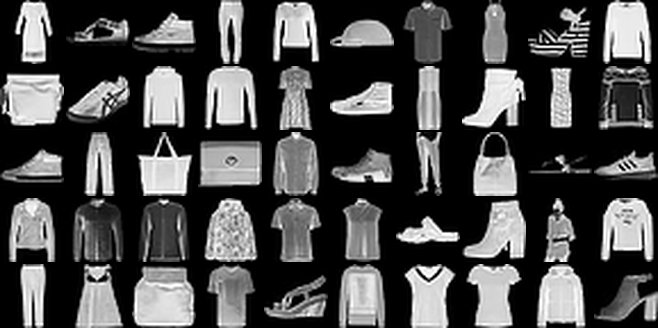

torch.Size([64, 1, 28, 28])


In [5]:
create_image_grid(test_dataset, 5, 10, cmap='gray', dark_mode=True)


x,y=next(iter(train_loader))
print(x.shape)

#### LeNet5Rev model

In [6]:
class LeNet5Rev(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 5*5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

In [7]:
# model summary
model = LeNet5Rev()
summarizer(model, input_size = (64,1,28,28))

Layer (type (var_name))                  Input Shape          Output Shape         Param #
LeNet5Rev (LeNet5Rev)                    [64, 1, 28, 28]      [64, 10]             --
├─Sequential (cnn_layers)                [64, 1, 28, 28]      [64, 16, 5, 5]       --
│    └─Conv2d (0)                        [64, 1, 28, 28]      [64, 6, 28, 28]      156
│    └─ReLU (1)                          [64, 6, 28, 28]      [64, 6, 28, 28]      --
│    └─MaxPool2d (2)                     [64, 6, 28, 28]      [64, 6, 14, 14]      --
│    └─Conv2d (3)                        [64, 6, 14, 14]      [64, 16, 10, 10]     2,416
│    └─ReLU (4)                          [64, 16, 10, 10]     [64, 16, 10, 10]     --
│    └─MaxPool2d (5)                     [64, 16, 10, 10]     [64, 16, 5, 5]       --
├─Sequential (classifier)                [64, 16, 5, 5]       [64, 10]             --
│    └─Flatten (0)                       [64, 16, 5, 5]       [64, 400]            --
│    └─Linear (1)                        [64,

#### Train Model

In [8]:
model = LeNet5Rev()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

#### View Model Performance

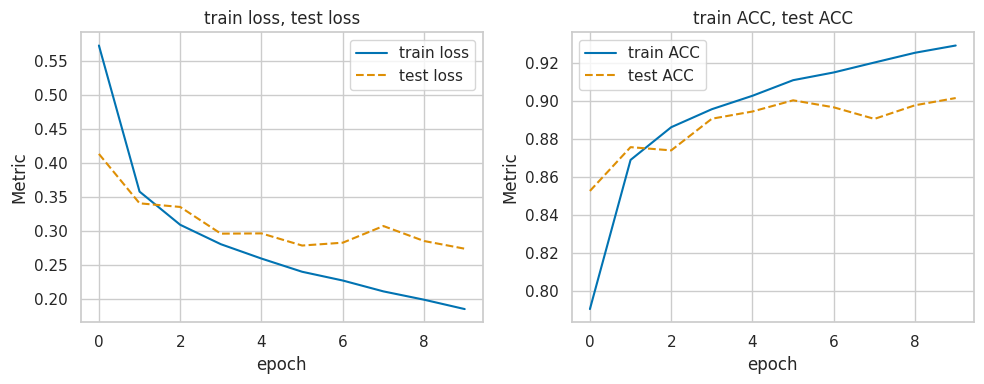

In [9]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

Model is overfitting training data

### Improve the model (24 pts)

Try increasing the number of convolutional layers up to six with ReLU layers.  You many need to increase
the number of channels (but not in every layer).  Use two max pooling layers.  Kernel size can be 3 or 5
but adjust the padding so that the convolutional layers preserve the size of the feature maps.

You can also simplify the classifier.  Try a single linear layer instead of multiple linear layers
separated by ReLU functions.

You should be able to achieve about 92% accuracy on the test set.  Show convergence plots for each model you try.   

You should try at least three different models.  Describe your experiments.  For each experiment include the model and plot convergence results.  

#### Improved Model 1

##### Model

Things that I tried:
<ol>
    <li> Increased channels from first layer to 32, keep that throughout. This improved the accuracy slightly but increased overfitting. </li>
    <li> Added a layer before the first pooling. This increased accuracy further but also increased overfitting. </li>
</ol>

In [10]:
class LeNet5Rev_NK_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 5*5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

In [11]:
# model summary
model = LeNet5Rev_NK_1()
summarizer(model, input_size = (64,1,28,28))

Layer (type (var_name))                  Input Shape          Output Shape         Param #
LeNet5Rev_NK_1 (LeNet5Rev_NK_1)          [64, 1, 28, 28]      [64, 10]             --
├─Sequential (cnn_layers)                [64, 1, 28, 28]      [64, 32, 5, 5]       --
│    └─Conv2d (0)                        [64, 1, 28, 28]      [64, 32, 28, 28]     832
│    └─ReLU (1)                          [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─Conv2d (2)                        [64, 32, 28, 28]     [64, 32, 28, 28]     25,632
│    └─ReLU (3)                          [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─MaxPool2d (4)                     [64, 32, 28, 28]     [64, 32, 14, 14]     --
│    └─Conv2d (5)                        [64, 32, 14, 14]     [64, 32, 10, 10]     25,632
│    └─ReLU (6)                          [64, 32, 10, 10]     [64, 32, 10, 10]     --
│    └─MaxPool2d (7)                     [64, 32, 10, 10]     [64, 32, 5, 5]       --
├─Sequential (classifier)               

##### Train Model

In [12]:
model = LeNet5Rev_NK_1()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_1.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev_NK_1 = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

##### Model Metrics

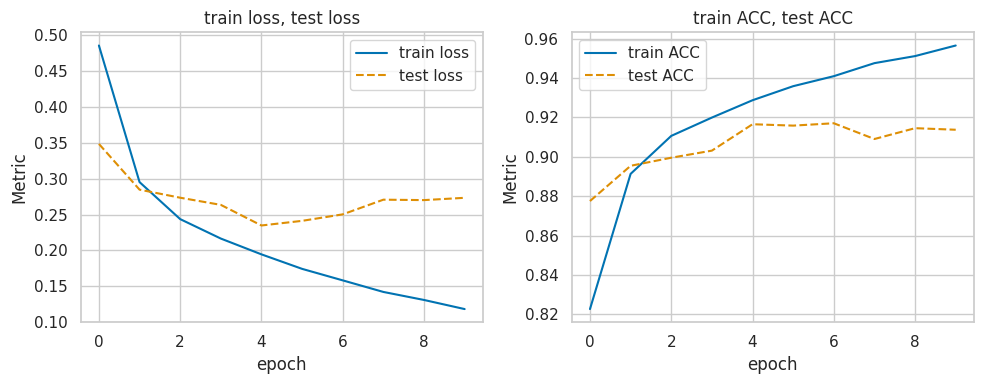

In [13]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev_NK_1,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

#### Improved Model 2

##### Model

Things I tried:
<ol>
    <li> Simplified the classifier to one linear layer. This didn't improve over fitting. </li>
    <li> Added another layer before the first pooling. This maybe improved accuracy but hard just doing once. </li>
    <li> Kept layers but reduced number of channels in early layers. Kept 32 channels in last CNN layer. Overfitting was maybe reduced slightly. </li>
    <li> Tried more channels early and then reducing them later. Overfitting was perhaps reduced but accuracy was reduced as well. </li>
    <li> Added even more channels to early CNN layers. This increased training accuracy but not test accuracy. Overfitting increased. </li>
    <li> Added a CNN layer after the first max pool. Intermediate number of channels. Improved accuracy slightly but still overfitting. </li>
    <li> Kept number of layers but reduced channels on every layer to 16, 8 for later layers. Reduced accuracy but improved overfitting. </li>
    <li> Went back to model 1. Added a CNN after the second pooling. Accuracy looks okay and overfitting is reduced. </li>
    <li> Reduced number of channels by half. Accuracy was lowered but over fitting was very low. </li>
    <li> Reverted channels. Added another layer after the second pooling. This didn't impact accuracy. </li>
    <li> Reverted that change. Added another layer after the first pooling. No change of accuracy. </li>
    <li> Reverted that change. Added padding to CNN layer before second pooling, increasing dimensions sent to clafficiation layers. Didn't make improvements. </li>
    <li> Reduced kernel size to 3 after first pooling. No real improvements. </li>
    <li> Did the oposite. Kernel size 3 for first three layers and then kernel size of five. Overfitting but accuracy at 92. </li>
    <li> Removed padding from last CNN so that the classifier recieved smaller, 3x3 WxH dimensions. Appears to be less overfitting and accuracy still at 92. </li>

</ol>

In [14]:
class LeNet5Rev_NK_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14
            
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),  # 14*14 -> 14*14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14 -> 7*7
            
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=0),   # 7*7->3*3
            nn.ReLU(),

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*3*3, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

##### Model Summary

In [15]:
# model summary
model = LeNet5Rev_NK_2()
summarizer(model, input_size = (64,1,28,28))

Layer (type (var_name))                  Input Shape          Output Shape         Param #
LeNet5Rev_NK_2 (LeNet5Rev_NK_2)          [64, 1, 28, 28]      [64, 10]             --
├─Sequential (cnn_layers)                [64, 1, 28, 28]      [64, 16, 3, 3]       --
│    └─Conv2d (0)                        [64, 1, 28, 28]      [64, 32, 28, 28]     320
│    └─ReLU (1)                          [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─Conv2d (2)                        [64, 32, 28, 28]     [64, 32, 28, 28]     9,248
│    └─ReLU (3)                          [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─MaxPool2d (4)                     [64, 32, 28, 28]     [64, 32, 14, 14]     --
│    └─Conv2d (5)                        [64, 32, 14, 14]     [64, 32, 14, 14]     25,632
│    └─ReLU (6)                          [64, 32, 14, 14]     [64, 32, 14, 14]     --
│    └─MaxPool2d (7)                     [64, 32, 14, 14]     [64, 32, 7, 7]       --
│    └─Conv2d (8)                        

##### Train Model

In [16]:
model = LeNet5Rev_NK_2()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_2.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev_NK_2 = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

##### Model Metrics

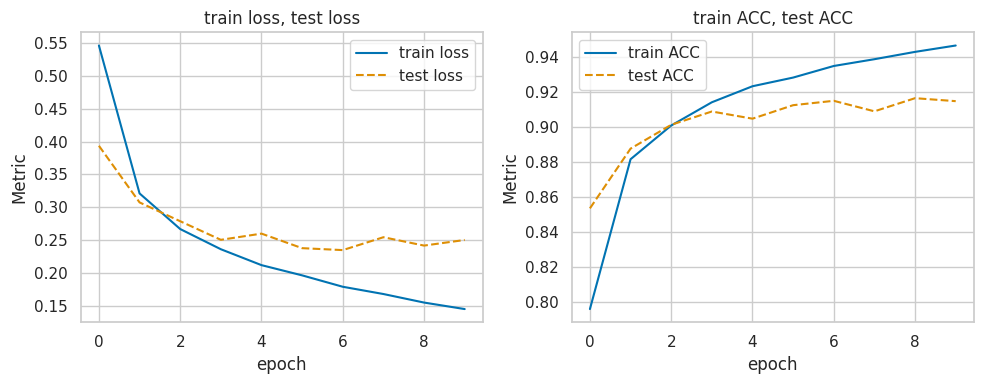

In [17]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev_NK_2,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

#### Model 3

#### Model

Things I tried:

<ol>
    <li> Added a bunch of channels, kept high throughout layers. This accuracy reaches 92% faster but increased overfitting </li>
    <li> Tried to decrease channels after second pooling. No changes. </li>
    <li> Decreased channels from 128 to 64 across all layers. No changes. </li>
    <li> Reduced classifier to one layer. Overfitting seemed to increase. </li>
    <li> Reverted classifier changes. Added another CNN after size transformed to 3x3. No change. </li>
    <li> Gave this new final CNN layer 128 out channels. More overfitting, no increase on accuracy. </li>
    <li> Removed the last layer. Added another CNN layer after first pooling. No change. </li>
    <li> Reverted that change. Ended with model from step 3. It reaches 92% accuracy after four epochs. Definetly some overfitting </li>
</ol>

In [18]:
class LeNet5Rev_NK_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),   # 28*28->32*32-->28*28
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),  # 14*14 -> 14*14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14 -> 7*7
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0),   # 7*7->3*3
            nn.ReLU(),

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*3*3, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

#### Model Summary

In [19]:
# model summary
model = LeNet5Rev_NK_3()
summarizer(model, input_size = (64,1,28,28))

Layer (type (var_name))                  Input Shape          Output Shape         Param #
LeNet5Rev_NK_3 (LeNet5Rev_NK_3)          [64, 1, 28, 28]      [64, 10]             --
├─Sequential (cnn_layers)                [64, 1, 28, 28]      [64, 64, 3, 3]       --
│    └─Conv2d (0)                        [64, 1, 28, 28]      [64, 64, 28, 28]     640
│    └─ReLU (1)                          [64, 64, 28, 28]     [64, 64, 28, 28]     --
│    └─Conv2d (2)                        [64, 64, 28, 28]     [64, 64, 28, 28]     36,928
│    └─ReLU (3)                          [64, 64, 28, 28]     [64, 64, 28, 28]     --
│    └─MaxPool2d (4)                     [64, 64, 28, 28]     [64, 64, 14, 14]     --
│    └─Conv2d (5)                        [64, 64, 14, 14]     [64, 64, 14, 14]     102,464
│    └─ReLU (6)                          [64, 64, 14, 14]     [64, 64, 14, 14]     --
│    └─MaxPool2d (7)                     [64, 64, 14, 14]     [64, 64, 7, 7]       --
│    └─Conv2d (8)                      

#### Train Model

In [20]:
model = LeNet5Rev_NK_3()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_3.pt'
epochs = 5

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev_NK_3 = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

##### Model Metrics

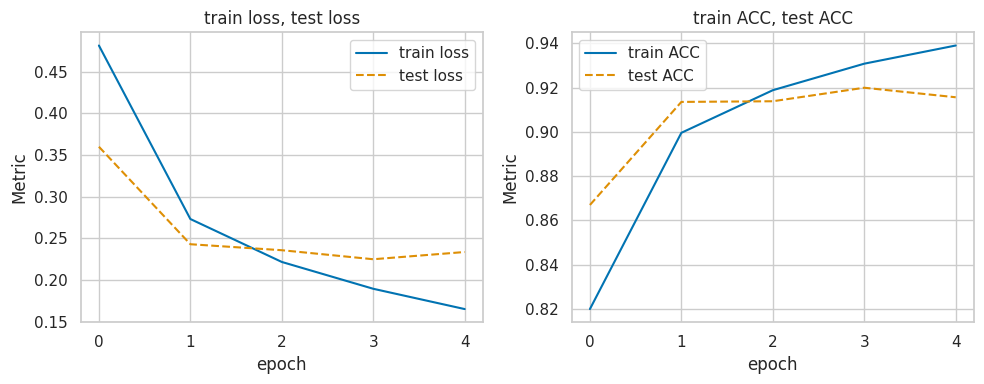

In [21]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev_NK_3,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

### Describe the things you tried (3 pts)

Summarize the network architectures you tried.  What worked best?  What didn't help?

Additional CNN Layers:
Adding a CNN layer before the first pooling and after the second pooling seemed to increase accuracy, while adding more layers did not provide further improvements.

Number of Channels:
Increasing the number of channels improved accuracy up to a point, but also drastically increased overfitting. For instance, 64 channels performed better than 32, but 128 channels did not outperform 64. The number of channels might benefit from further fine-tuning.

Kernel Size:
Using a kernel size of 3 before the first pooling, then switching to a kernel size of 5 increased accuracy. Additionally, providing the classification layers with smaller WxH dimensions (3x3) potentially reduced overfitting.

### Analyze your best model (8 pts)

Make a confusion matrix for the predictions of your best model on the test set.  You can set `use_class_labels = True` when using `evaluate_classifier` to see the names of the classes.  You can also access the names of the classes as an attribute of the dataset, e.g. `dataset.classes`.

Describe which classes get most confused by your model.  Plot examples of the images that your model is getting wrong.  Do these misclassifications make sense?  Are the images from the misclassified classes hard to distinguish by eye?

#### Confusion Matrix

The dataset has 10000 samples.
The model misclassified 844 samples.


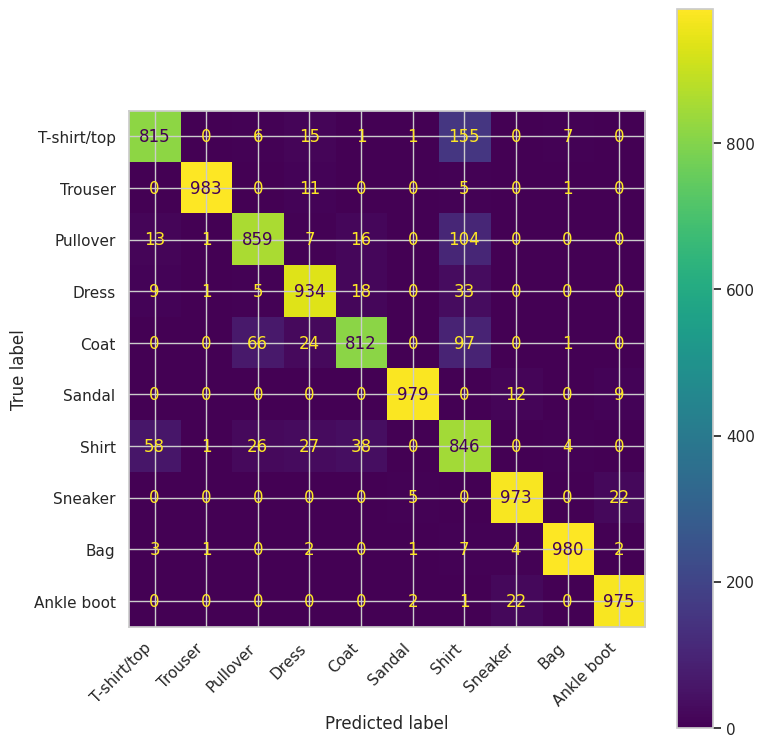

In [22]:
model = load_model(LeNet5Rev_NK_3, MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_3.pt', device)
conf_mat,report,missed_dataset=evaluate_classifier(model, test_dataset, device, img_size=(8,8),use_class_labels=True)


#### Misclassification Examples

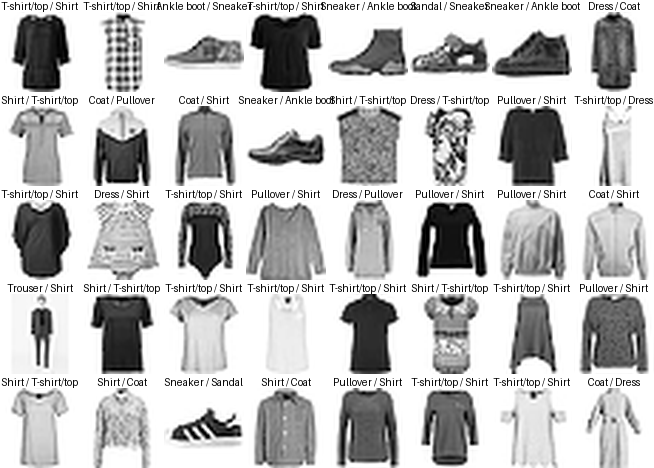

In [23]:
create_image_grid(missed_dataset, nrows=5, ncols=8, img_size=(80,80), show_labels=True, 
                  cmap='Greys', mean=mean[0], std=std[0], dark_mode=False)

Overall, the predictions make sense. Misclassifications typically involve clothing items of a similar type. For example, a shirt might be misclassified as a t-shirt, and a coat might be misclassified as a pullover. These are understandable mistakes that would be difficult for most humans to consistently predict. By eye, the images appear to be extremely blurry, making it even more impressive that the model is able to classify them so accurately. Nearly every misclassification example would be hard for humans to predict.